# Exploración

***¿Qué se necesita para correr el modelo?***

In [ ]:
# Módulos necesarios
import numpy as np
import seaborn
from scipy.integrate import odeint
from matplotlib import pyplot as plt
#from matplotlib import colorbar as cbar
#from matplotlib import colors as colors

In [ ]:
# %matplotlib # abre una ventana interactiva con más opciones
%matplotlib notebook

In [ ]:
%matplotlib inline

In [ ]:
np.set_printoptions(precision=3)

## Paisaje
Primero, crear el paisaje:

In [ ]:
# Parámetro iniciales
x_celdas = 10 # numero celdas en x
y_celdas = 10 # numero celdas en y
numerodemilpas = 95 # sería mejor intercambiar este valor por un porcentaje

In [ ]:
%run genera_tipo_matriz_agroecologica.py # debe estar en el mismo directorio

In [ ]:
paisaje = genera_tipo_matriz_agroecologica(x_celdas, y_celdas, n_bosque=5, 
                                           posicion_bosque=[(1,1),(1,8),(4,5),(8,1),(8,8)], 
                                           n_milpa=numerodemilpas, posicion_milpa="random")

In [138]:
paisaje

[['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm'],
 ['m', 'b', 'm', 'm', 'm', 'm', 'm', 'm', 'b', 'm'],
 ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm'],
 ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm'],
 ['m', 'm', 'm', 'm', 'm', 'b', 'm', 'm', 'm', 'm'],
 ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm'],
 ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm'],
 ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm'],
 ['m', 'b', 'm', 'm', 'm', 'm', 'm', 'm', 'b', 'm'],
 ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']]

In [ ]:
type(paisaje)

In [ ]:
len(paisaje)

In [ ]:
len(paisaje[1])

El `paisaje` está representado por una lista con `len(paisaje)` igual a `y_celdas`.  A su vez, cada elemento de `paisaje` es una lista de `x_celdas` elementos.

Sería conveniente crear el paisaje como un arreglo numérico de numpy desde el inicio, como en la función `heatmap_tipo()`:
```
def heatmap_tipo(name,tipo,m_milpa=.5,m_intensivo=1):
    for i in range(len(tipo)):
        for j in range(len(tipo[0])):
            if tipo[i][j] == 'b': tipo[i][j] = 1.
            if tipo[i][j] == 'm': tipo[i][j] = 1-m_milpa
            if tipo[i][j] == 'i': tipo[i][j] = 1-m_intensivo
    tipo = np.array(tipo)
    plotHeatmap(name, tipo) #estado inicial
```

## Comunidad
Ahora, crear la comunidad, que debe incluir toda la información para el sistema Lotka-Volterra: la matriz de interacciones, las condiciones iniciales y las tasas de reproducción. Utilizaremos las que ya están creadas.

In [139]:
condiciones_iniciales = np.loadtxt("Fri-Jan-30-114423-2015-c.txt")
tasas_reproduccion = np.loadtxt("Fri-Jan-30-114423-2015-v.txt")
matriz_interacciones = np.loadtxt("Fri-Jan-30-114423-2015-m.txt")

In [ ]:
print matriz_interacciones

In [ ]:
seaborn.heatmap(matriz_interacciones)

### Identidades

In [ ]:
% run vector_identidades.py # sólo funciona con la matriz de 1, 0 y -1

In [ ]:
def vector_identidades_2(matriz_interacciones):
    """Dada una matriz de interacciones tróficas, 
    identificar especies basales, intermedias y top.
    Entra: matriz de interacciones tróficas, que es una matriz cuadrada
    Sale: vector con 0=intermedia, 1=basal, 2=top
    """
    # Convertir a matriz de -1, 0 y 1 para usar función vector_identidades()
    interacciones_negativas = matriz_interacciones[:, :] < 0.0
    interacciones_positivas = matriz_interacciones[:, :] > 0.0
    
    matriz_interacciones[interacciones_negativas] = -1
    matriz_interacciones[interacciones_positivas] = 1
    
    a = matriz_interacciones
    n_especies = a.shape[0]
    
    # Lo que sigue es el código original en la función vector_identidades()
    
    identidades = np.zeros(n_especies) #inicia vector con ceros, 
                                       #terminará 0=intermedia, 1=basal, 2=top
    #Basales (sólo un -1 en la matriz de nicho original)    
    matrizbasales = a*-1  #ahora sólo no simportan los 1    
    matrizbasales[matrizbasales<=0] = 0  
    # print matrizr    
    for i in range (len(matrizbasales)):
    #    print sum(matrizr[:,i])
        if sum(matrizbasales[:,i])==1: #si son basales (solo tienen un uno)
            #print "la especie", i, "es basal"
            identidades[i]=1
        else: pass    
    #Top (al menos dos -1 y ningún 1 en la original)    
    matriztop = a*1
    matriztop[matriztop >= 0] = 0        
    for i in range (len(a)):
        if sum(a[:,i]) == sum(matriztop[:,i]):
            #print "la especie", i, "es top"
            identidades[i]=2
        else: pass    
    
    return identidades, a

In [ ]:
identidades, matriz_interacciones_2 = vector_identidades_2(matriz_interacciones)
print identidades
print tasas_reproduccion
seaborn.heatmap(matriz_interacciones_2)

### Sistema Lotka-Volterra sin espacio

In [ ]:
def d_lotkavolterra_alea(x, t, r_alea, a_alea): 
    """
    Ecuacion de lotka volterra generalizada ESTA ES LA QUE SE USA
    """
    dx = x * (r_alea + np.dot(a_alea, x))
    return dx

In [ ]:
def correr_aleatorizado_sin_matriz(t_total, f, r_alea, a_alea, x_0, identidades, plot=False): 
    """
    Corre el sistema con la ecuacion lotka volterra.
    Regresa la población al final de t_total iteraciones.
    """
    n_especies = a_alea.shape[0]
    # global x_0
    #x_0 = 1/(np.random.random(n_especies)) #pob inicial aleatoria mayor a 1 EL QUE USÉ
    #x_0 = Nombres[actual][0] #iniciando con condiciones guardadas
    #x_0 = puntofijo #inciando desde los puntos fijos
    t = np.linspace(0, t_total,t_total+1)
    x = odeint(f, x_0, t, args=(r_alea,a_alea))
    if plot:
        fig = plt.figure()
        fig.add_subplot(111)
        plt.plot(t, x, color="blue")
        plt.show()  
    return x[-1]

In [ ]:
t_total = 20
x = correr_aleatorizado_sin_matriz(t_total, 
                                   d_lotkavolterra_alea, 
                                   tasas_reproduccion, 
                                   matriz_interacciones, 
                                   condiciones_iniciales, 
                                   identidades)

### Incorporando la intensidad de manejo

In [ ]:
def d_lotkavolterra_alea_2(x, t, r_alea, a_alea, manejo): 
    """
    Ecuacion de lotka volterra generalizada que incorpora la intensidad de manejo
    En esta forma, equivale a que el proceso ocurra más lento
    """
    dx = manejo * x * (r_alea + np.dot(a_alea, x))
    return dx

In [ ]:
def d_lotkavolterra_alea_3(x, t, r_alea, a_alea, manejo): 
    """
    Ecuacion de lotka volterra generalizada que incorpora la intensidad de manejo.
    **De esta forma, la población crece en forma proporcional al manejo.
    Verificar si funciona para todas las especies / niveles tróficos!
    """
    dx = x * (manejo * r_alea + np.dot(a_alea, x))
    return dx

In [ ]:
tasas_reproduccion_lv3 = np.loadtxt("Fri-Jan-30-114423-2015-v.txt")
print tasas_reproduccion_lv3

tasas_reproduccion_lv3 = tasas_reproduccion_lv3 * 0.3

print tasas_reproduccion_lv3
vector_identidades_2(matriz_interacciones)[0]

In [ ]:
def d_lotkavolterra_alea_4(x, t, r_alea, a_alea, manejo): 
    """
    Ecuacion de lotka volterra generalizada que incorpora la intensidad de manejo.
    En esta forma, las tasas de muerte, que son los coeficientes en la diagonal 
    de la matriz de interacciones
    """
    #tasas_muerte = np.diagonal(a_alea)
    #print tasas_muerte
    #print a_alea
    #tasas_muerte = tasas_muerte * manejo
    #print tasas_muerte
    
    #diagonal = np.diag_indices(a_alea.shape[0])
    #a_alea[diagonal] = tasas_muerte
    #print a_alea
    
    dx = x * (r_alea + np.dot(a_alea, x))
    return dx

In [ ]:
# Modificar tasas de muerte fuera de la función:
matriz_interacciones_lv4 = np.loadtxt("Fri-Jan-30-114423-2015-m.txt")
print matriz_interacciones_lv4

tasas_muerte = np.diagonal(matriz_interacciones_lv4)
diagonal = np.diag_indices(10)
print tasas_muerte
tasas_muerte = tasas_muerte * (1/0.7)
print tasas_muerte
matriz_interacciones_lv4[diagonal] = tasas_muerte
print matriz_interacciones_lv4
print matriz_interacciones

# En realidad, las tasas de muerte son el efecto que tiene la especie sobre sí misma,
# ¿tiene sentido que la intensidad de manejo influya en esto?
# Creo que tiene más sentido modificar las tasas de crecimiento como en 
# d_lotkavolterra_alea_3()



In [ ]:
vector_identidades_2(matriz_interacciones)[0]

In [ ]:
t_total = 300
t = np.linspace(0, t_total,t_total+1)

#original = odeint(d_lotkavolterra_alea, condiciones_iniciales, t, 
#           args=(tasas_reproduccion,matriz_interacciones))

manejo = 1.0 # bosque
x = odeint(d_lotkavolterra_alea_3, condiciones_iniciales, t, 
           args=(tasas_reproduccion,matriz_interacciones, manejo))

manejo = 0.7 # milpa
y = odeint(d_lotkavolterra_alea_3, condiciones_iniciales, t, 
           args=(tasas_reproduccion,matriz_interacciones,manejo))

manejo = 0.4 # 
z = odeint(d_lotkavolterra_alea_3, condiciones_iniciales, t, 
           args=(tasas_reproduccion,matriz_interacciones,manejo))

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
#plt.plot(t, original[:,[0, 1, 2]], color="red")
plt.plot(t, x[:,[2]], color="blue")
plt.plot(t, y[:, [2]], color="green")
plt.plot(t, z[:, [2]], color="red")
plt.show() 

## Modelo

Se supone que el modelo sólo necesita como entrada un **paisaje** y una **comunidad**. 

Además, hay algunos parámetros que se pueden modificar, como las tasas de dispersión y de muerte diferencial, el tiempo total de simulación y las iteraciones de migración y muerte entre cada una de Lotka-Volterra.

In [ ]:
# Obtenemos el número de especies de la matriz de interacciones, que debe ser cuadrada
n_especies = matriz_interacciones.shape[1]

Disp = {'b':0.3, 'm':1.0, 'i':1.0} #tasas dipersión para nueva función migracion_esp

m_milpa = 0.3 # tasa muerte negra cte o np.array 
                # (//¿por qué o para qué esto puede ser un arreglo?//)
m_intensivo = 0.6 # tasa muerte blanca cte o np.array

h = 0.001 #diferencial de cambio en t (euler y graficas)
t_total = 1000 #tiempo total de simulacion
iter_difymuerte = 1 #iteraciones de dif y muerte entre cada una de lotka volterra

Lo siguiente es poblar el paisaje con las condiciones iniciales o con una población aleatoria. En la versión actual se eligen condiciones iniciales para cada tipo de celda (bosque, milpa o intensivo).

In [140]:
%run genera_poblacion_inicial.py # debe estar en el mismo directorio

In [141]:
poblacion_0 = genera_poblacion_inicial(paisaje, n_especies, 
                                       p0_bosque = condiciones_iniciales, p0_milpa=0, 
                                       p0_intensivo=0)

<string>:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
<string>:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
poblacion_0.shape

In [ ]:
# Convertir el paisaje a un arreglo numérico
for i in range(len(paisaje)):
        for j in range(len(paisaje[0])):
            if paisaje[i][j] == 'b': paisaje[i][j] = 1.
            if paisaje[i][j] == 'm': paisaje[i][j] = 1-m_milpa
            if paisaje[i][j] == 'i': paisaje[i][j] = 1-m_intensivo
paisaje_numerico = np.array(paisaje)

In [ ]:
# Probando seaborn para graficar el paisaje
seaborn.set()
uniform_data = np.random.rand(10, 12)
ax = seaborn.heatmap(uniform_data)
uniform_data.shape

In [ ]:
seaborn.heatmap(paisaje_numerico, cmap="Greens")

Necesitamos separar las funciones para medidas de biodiversidad:
* *riqueza*: cantidad de especies vivas (con más de 0.001 "individuos").
* *biomasa*: cantidad total de individuos. 

In [ ]:
def riqueza(poblacion):
    """ Entrada: un arreglo poblacion = [tiempo] [x][y] [especieA][especieB][...]
        Salida: la riqueza de especies en la última iteración, en todo el paisaje.
    """
    riqueza = []
    for idx in range(n_especies): # cambiar n_especies por poblacion.shape[3]??
        #print np.sum(poblacion[-1,:,:,idx]) #suma de cada especie en la última iteración
        if np.sum(poblacion[-1,:,:,idx]) > 0.0001:
            riqueza.append(1)  #vivos arriba de 0.0001   
    #print np.sum(poblacion[-1,:,:,:]) #suma total de individuos al final de n iteraciones
    return np.sum(riqueza) #riqueza de especies al final de n iteraciones

In [ ]:
poblacion_con_tiempo = [poblacion_0]
poblacion_con_tiempo = np.array(poblacion_con_tiempo)
poblacion_con_tiempo.shape
riqueza(poblacion_con_tiempo)

In [ ]:
def medidas_por_celda(poblacion, t=-1):
    """
    Entra un arreglo 4D con la forma: 
    poblacion = [tiempo] [x] [y] [especies]
    Produce arreglos 2D que indican la biomasa y la riqueza 
    de cada celda de poblacion en UN tiempo; 
    si no se indica el tiempo, se toma la última iteración
    """
    poblacion = poblacion[t]
    biomasa = np.zeros((poblacion.shape[0], poblacion.shape[1]))
    riqueza = np.zeros((poblacion.shape[0], poblacion.shape[1]))

    for x in range(poblacion.shape[0]):
        for y in range(poblacion.shape[1]):
            biomasa[x] [y] = np.sum(poblacion[x, y, :])
            riqueza[x] [y] = np.sum(poblacion[x, y, :] > 0.001)
              
    return biomasa, riqueza

In [ ]:
biomasa_0 = medidas_por_celda(poblacion_con_tiempo)[0]
#poblacion_con_tiempo[-1].shape[0]
#np.sum(condiciones_iniciales)
seaborn.heatmap(biomasa_0)

In [ ]:
riqueza_0 = medidas_por_celda(poblacion_con_tiempo)[1]
seaborn.heatmap(riqueza_0)

## Corriendo el modelo original

In [ ]:
%run modelo.py

In [ ]:
# Obtenemos el número de especies de la matriz de interacciones, que debe ser cuadrada
n_especies = matriz_interacciones.shape[1]

Disp = {'b':0.3, 'm':1.0, 'i':1.0} #tasas dipersión para nueva función migracion_esp

m_milpa = 0.3 # tasa muerte negra cte o np.array 
                # (//¿por qué o para qué esto puede ser un arreglo?//)
m_intensivo = 0.6 # tasa muerte blanca cte o np.array

h = 0.001 #diferencial de cambio en t (euler y graficas)
t_total = 1000 #tiempo total de simulacion
iter_difymuerte = 1 #iteraciones de dif y muerte entre cada una de lotka volterra

poblacion = correr_2DMM(poblacion_0, 
                        paisaje, 
                        t_total, 
                        n_especies, 
                        d_lotkavolterra_alea, 
                        tasas_reproduccion, 
                        matriz_interacciones, 
                        m_milpa, m_intensivo, Disp, 'vecinos8', iter_difymuerte = 1)

In [ ]:
biomasa = medidas_por_celda(poblacion)[0]
seaborn.heatmap(biomasa)

In [ ]:
riqueza = medidas_por_celda(poblacion, 50)[1]
seaborn.heatmap(riqueza, vmin = 0, vmax = 10)
#print riqueza

## Modelo 2

En todos los parches ocurren interacciones ecológicas, es decir, los individuos se establecen en todos los parches. La dinámica de poblaciones depende de la intensidad de manejo del parche.
Usaré las mismas tasas de dispersión, la misma comunidad, el mismo paisaje y el mismo valor `iter_difymuerte = 1`.

In [145]:
%run modelo2.py

In [146]:
# Obtenemos el número de especies de la matriz de interacciones, que debe ser cuadrada
n_especies = matriz_interacciones.shape[1]

Disp = {'b':0.3, 'm':1.0, 'i':1.0} #tasas dipersión no cambian por el momento


# Ya no necesitamos estos parámetros
# Excepto, quizá para obtener los valores numéricos del manejo
m_milpa = 0.3
m_intensivo = 0.6

h = 0.001 #diferencial de cambio en t (euler y graficas)
t_total = 1000 #tiempo total de simulacion
iter_difymuerte = 1 #iteraciones de dif y muerte entre cada una de lotka volterra

poblacion = correr_2DMM_2(poblacion_0, 
                        paisaje, 
                        t_total, 
                        n_especies, 
                        d_lotkavolterra_alea_3, 
                        tasas_reproduccion, 
                        matriz_interacciones, 
                        m_milpa, m_intensivo, Disp, 'vecinos8', iter_difymuerte = 1)

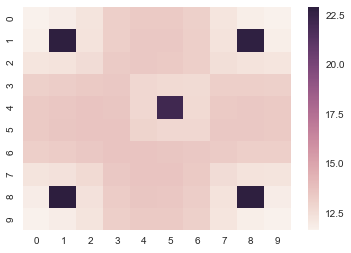

In [151]:
biomasa = medidas_por_celda(poblacion)[0]
seaborn.heatmap(biomasa)

[[ 5.  5.  4.  4.  4.  4.  4.  5.  5.  5.]
 [ 5.  5.  4.  4.  4.  4.  4.  5.  5.  5.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  5.  5.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  5.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 4.  5.  4.  4.  4.  4.  4.  4.  5.  5.]
 [ 5.  4.  4.  4.  4.  4.  4.  4.  5.  5.]]


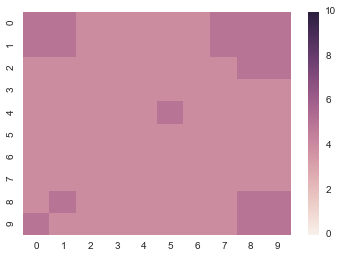

In [163]:
riqueza = medidas_por_celda(poblacion, 950)[1]
seaborn.heatmap(riqueza, vmin = 0, vmax = 10)
print riqueza

In [134]:
# Execute this cell to load the notebook's style sheet, then ignore it
# (From numericalmooc by Lorena Barba)
from IPython.core.display import HTML
css_file = "C:\Users\hp\Desktop\proyectof\style.css"
HTML(open(css_file, "r").read())